**Get COVID-19 data from Github**

In [ ]:
! git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2966 (delta 65), reused 90 (delta 40), pack-reused 2845
Receiving objects: 100% (2966/2966), 563.67 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (1169/1169), done.
Checking out files: 100% (890/890), done.


**Get normal chest X-ray data from Kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
# Upload Kaggle API key

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabrieldaely","key":"26bf1049d09710bdea490aa8549a8716"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

100% 2.28G/2.29G [00:31<00:00, 24.1MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.7MB/s]


In [ ]:
! ls

chest-xray-pneumonia.zip  covid-chestxray-dataset  kaggle.json	sample_data


In [ ]:
! unzip -q chest-xray-pneumonia.zip

In [ ]:
! rm -r chest-xray-pneumonia.zip

**Data preparation**

In [ ]:
import pandas as pd
import os
import random
from shutil import copyfile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

COVID-19 data

In [ ]:
metadata = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
metadata = metadata[['finding','modality','folder','filename']]

In [ ]:
metadata

,finding,modality,folder,filename
0,COVID-19,X-ray,images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,COVID-19,X-ray,images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,COVID-19,X-ray,images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,COVID-19,X-ray,images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,COVID-19,X-ray,images,nejmc2001573_f1a.jpeg
...,...,...,...,...
668,COVID-19,X-ray,images,covid-19-caso-95-2-16.png
669,COVID-19,X-ray,images,covid-19-caso-95-3-14.png
670,COVID-19,X-ray,images,covid-19-caso-95-4-12.png
671,COVID-19,X-ray,images,covid-19-caso-99-1-19.png


In [ ]:
metadata = metadata[metadata['finding'] == 'COVID-19']

In [ ]:
metadata = metadata[metadata['modality'] == 'X-ray']

In [ ]:
metadata

,finding,modality,folder,filename
0,COVID-19,X-ray,images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,COVID-19,X-ray,images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,COVID-19,X-ray,images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,COVID-19,X-ray,images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,COVID-19,X-ray,images,nejmc2001573_f1a.jpeg
...,...,...,...,...
668,COVID-19,X-ray,images,covid-19-caso-95-2-16.png
669,COVID-19,X-ray,images,covid-19-caso-95-3-14.png
670,COVID-19,X-ray,images,covid-19-caso-95-4-12.png
671,COVID-19,X-ray,images,covid-19-caso-99-1-19.png


Create source folders for each dataset

In [ ]:
COVID_DIR = './covid/'
NORMAL_DIR = './normal/'

# Create folders for each dataset
try:
    os.mkdir(COVID_DIR)
    os.mkdir(NORMAL_DIR)
except OSError:
    pass

# COVID-19 data
for _, row in metadata.iterrows():
    copyfile('./covid-chestxray-dataset/' + row['folder'] + '/' + row['filename'],
             './covid/' + row['filename'])

# Normal data
file_list = os.listdir('./chest_xray/train/NORMAL/')
file_list = random.sample(file_list,len(file_list))
file_list = file_list[:500]
for file in file_list:
    copyfile('./chest_xray/train/NORMAL/' + file,
             './normal/' + file)

Split data to train and test dataset

In [ ]:
MAIN_DIR = './normal-covid/'
TRAIN_DIR = './normal-covid/train/'
TEST_DIR = './normal-covid/test/'
TRAIN_COVID_DIR = './normal-covid/train/covid/'
TRAIN_NORMAL_DIR = './normal-covid/train/normal/'
TEST_COVID_DIR = './normal-covid/test/covid/'
TEST_NORMAL_DIR = './normal-covid/test/normal/'

# Create train and test folder for each dataset
try:
    os.mkdir(MAIN_DIR)
    os.mkdir(TRAIN_DIR)
    os.mkdir(TEST_DIR)
    os.mkdir(TRAIN_COVID_DIR)
    os.mkdir(TRAIN_NORMAL_DIR)
    os.mkdir(TEST_COVID_DIR)
    os.mkdir(TEST_NORMAL_DIR)
except OSError:
    pass

# Define a function to automate dataset splitting
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    file_list = os.listdir(SOURCE)
    file_list = random.sample(file_list,len(file_list))
    train_size = round(SPLIT_SIZE * len(file_list))
    
    for file in file_list[:train_size]:
        copyfile(SOURCE + file, TRAINING + file)
    for file in file_list[train_size:]:
        copyfile(SOURCE + file, TESTING + file)

# Split each dataset
split_size = 0.9
split_data(COVID_DIR, TRAIN_COVID_DIR, TEST_COVID_DIR, split_size)
split_data(NORMAL_DIR, TRAIN_NORMAL_DIR, TEST_NORMAL_DIR, split_size)

In [ ]:
print(len(os.listdir(TRAIN_COVID_DIR)))
print(len(os.listdir(TRAIN_NORMAL_DIR)))
print(len(os.listdir(TEST_COVID_DIR)))
print(len(os.listdir(TEST_NORMAL_DIR)))

401
450
45
50


Create train and validation data generator

In [ ]:
# Create train data generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
	TRAIN_DIR,
	target_size=(256,256),
	class_mode='binary',
    batch_size=32
)

# Create test/validation data generator

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(256,256),
	class_mode='binary',
    batch_size=32
)

Found 851 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


**Build and train the model**

In [ ]:
do = 0.3

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(256, 256, 3)),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(do),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(do),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            if(logs.get('val_accuracy')>0.95):
                print("\nReached 95% accuracy. Stopping training!")
                self.model.stop_training = True

callbacks = myCallback()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 50, 
                    validation_data = test_generator, callbacks = [callbacks],
                    verbose = 1)

Epoch 1/50
27/27 [==============================] - 35s 1s/step - loss: 2.8226 - accuracy: 0.5029 - val_loss: 0.6655 - val_accuracy: 0.5263
Epoch 2/50
27/27 [==============================] - 35s 1s/step - loss: 0.5724 - accuracy: 0.7297 - val_loss: 0.5288 - val_accuracy: 0.8947
Epoch 3/50
27/27 [==============================] - 35s 1s/step - loss: 0.4618 - accuracy: 0.8120 - val_loss: 0.5394 - val_accuracy: 0.8421
Epoch 4/50
27/27 [==============================] - 35s 1s/step - loss: 0.5185 - accuracy: 0.8226 - val_loss: 0.5243 - val_accuracy: 0.8632
Epoch 5/50
27/27 [==============================] - 35s 1s/step - loss: 0.4633 - accuracy: 0.8331 - val_loss: 0.5712 - val_accuracy: 0.7789
Epoch 6/50
27/27 [==============================] - 35s 1s/step - loss: 0.4119 - accuracy: 0.8778 - val_loss: 0.3278 - val_accuracy: 0.9158
Epoch 7/50
27/27 [==============================] - 36s 1s/step - loss: 0.3261 - accuracy: 0.8790 - val_loss: 0.3401 - val_accuracy: 0.8947
Epoch 8/50
27/27 [==

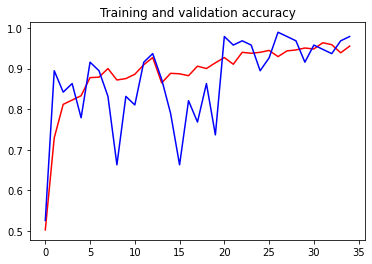

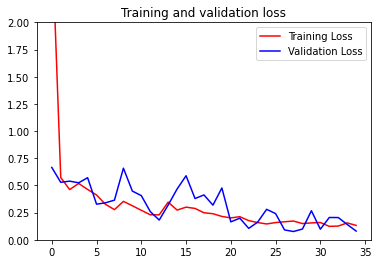

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim(0,2)
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Save model**

In [ ]:
model.save('normal_covid_model95.h5')